In [ ]:
X_vars = [
    "Air Temp (°F)",
    "0.5 m Air Temp (°F)",
    "1.5 m Air Temp (°F)",
    "3 m Air Temp (°F)",
    "Relative Humidity (%)",
    "Precipitation (in)",
    "Accumulated Precip (in)",
    "Solar Radiation (W / m²)",
    "Wind Speed (mph)",
    "Wind Direction (°)",
    "Wind Gust (mph)",
    '4" Bare Soil Temp (°F)',
    '4" Grass Soil Temp (°F)',
    '2" Soil Temp (°F)',
    '2" Soil Water Content (%)',
    '4" Soil Temp (°F)',
    '8" Soil Temp (°F)',
    '8" Soil Water Content (%)',
    '20" Soil Temp (°F)',
    '20" Soil Water Content (%)',
    "Inversion Strength",
    "Max Inversion",
]


In [2]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("Table_Hrly_ACRE_clean.csv")

# Set time index
df["Time (LST)"] = pd.to_datetime(df["Time (LST)"])
df = df.set_index("Time (LST)")

# Y variable
Y_var = '4" Soil Water Content (%)'

# X variable subset DataFrame
df_X = df[X_vars]

# Target variable series
df_Y = df[Y_var]

print("X shape:", df_X.shape)
print("Y shape:", df_Y.shape)


X shape: (1363, 22)
Y shape: (1363,)


In [3]:
# Interpolate missing values in X and Y
df_X_interp = df_X.interpolate(method="time").fillna(method="bfill").fillna(method="ffill")
df_Y_interp = df_Y.interpolate(method="time").fillna(method="bfill").fillna(method="ffill")

print("Any NaNs left in X?:", df_X_interp.isna().any().any())
print("Any NaNs left in Y?:", df_Y_interp.isna().any().any())


Any NaNs left in X?: False
Any NaNs left in Y?: False


/var/folders/1b/9b4m32_9491bc76v2y8h5vt80000gn/T/ipykernel_7973/3166745694.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_X_interp = df_X.interpolate(method="time").fillna(method="bfill").fillna(method="ffill")
/var/folders/1b/9b4m32_9491bc76v2y8h5vt80000gn/T/ipykernel_7973/3166745694.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_Y_interp = df_Y.interpolate(method="time").fillna(method="bfill").fillna(method="ffill")


In [4]:
from statsmodels.tsa.stattools import adfuller

# Combine all variables into one dataframe
df_all = pd.concat([df_X_interp, df_Y_interp], axis=1)

def adf_test(series, name):
    result = adfuller(series.dropna(), autolag="AIC")
    stat, pvalue = result[0], result[1]
    print(f"\n{name}")
    print(f"ADF Statistic: {stat:.4f}")
    print(f"p-value: {pvalue:.4f}")
    if pvalue < 0.05:
        print("=> Stationary")
    else:
        print("=> NOT Stationary")
    return pvalue

non_stationary = []

print("Running ADF test on all variables...")
for col in df_all.columns:
    p = adf_test(df_all[col], col)
    if p >= 0.05:
        non_stationary.append(col)

print("\nNon-stationary variables:")
print(non_stationary)


Running ADF test on all variables...

Air Temp (°F)
ADF Statistic: -3.0352
p-value: 0.0317
=> Stationary

0.5 m Air Temp (°F)
ADF Statistic: -3.0946
p-value: 0.0270
=> Stationary

1.5 m Air Temp (°F)
ADF Statistic: -3.1185
p-value: 0.0252
=> Stationary

3 m Air Temp (°F)
ADF Statistic: -3.0964
p-value: 0.0268
=> Stationary

Relative Humidity (%)
ADF Statistic: -3.6840
p-value: 0.0043
=> Stationary

Precipitation (in)
ADF Statistic: -6.8496
p-value: 0.0000
=> Stationary

Accumulated Precip (in)
ADF Statistic: -6.8496
p-value: 0.0000
=> Stationary

Solar Radiation (W / m²)
ADF Statistic: -4.0085
p-value: 0.0014
=> Stationary

Wind Speed (mph)
ADF Statistic: -4.6418
p-value: 0.0001
=> Stationary

Wind Direction (°)
ADF Statistic: -4.5898
p-value: 0.0001
=> Stationary

Wind Gust (mph)
ADF Statistic: -4.4520
p-value: 0.0002
=> Stationary

4" Bare Soil Temp (°F)
ADF Statistic: -2.8980
p-value: 0.0456
=> Stationary

4" Grass Soil Temp (°F)
ADF Statistic: -3.7782
p-value: 0.0031
=> Stationary


In [5]:
import pandas as pd

# Load interpolated dataset
df_stationary = pd.concat([df_X_interp, df_Y_interp], axis=1)

# List of non-stationary variables to difference
non_stationary_vars = [
    '2" Soil Water Content (%)',
    '8" Soil Water Content (%)',
    '20" Soil Water Content (%)',
    '4" Soil Water Content (%)'   # Y
]

# Apply first difference
for col in non_stationary_vars:
    df_stationary[col] = df_stationary[col].diff()

# Drop the first row (it becomes NaN after differencing)
df_stationary = df_stationary.dropna()

# Save stationary dataset
df_stationary.to_csv("Table_Hrly_ACRE_stationary.csv")

print("Stationary dataset created and saved as Table_Hrly_ACRE_stationary.csv")
print("Shape:", df_stationary.shape)


Stationary dataset created and saved as Table_Hrly_ACRE_stationary.csv
Shape: (1362, 23)


In [9]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

Y_var = '4" Soil Water Content (%)'

best_lags = {}
p_values = {}
importance = {}

print("\n==== Granger Lag Selection and Importance Assessment ====\n")

for X in X_vars:

    print(f"\n--- Processing variable: {X} ---")

    # Build two-column dataframe [Y, X]
    data_pair = df_stationary[[Y_var, X]]

    # Store AIC per lag
    aic_values = {}

    for lag in range(1, 13):
        try:
            result = grangercausalitytests(data_pair, maxlag=lag, verbose=False)
            model = result[lag][1]     # OLS regression result
            aic = model.aic
            aic_values[lag] = aic
        except Exception as e:
            print(f"    Lag {lag} failed: {e}")
            continue

    if len(aic_values) == 0:
        print(f"  No valid lags found for {X}. Skipping.")
        continue

    # Choose lag with minimum AIC
    best_lag = min(aic_values, key=aic_values.get)
    best_lags[X] = best_lag

    print(f"  Best lag (AIC): {best_lag}")

    # Run Granger at best lag and extract stats
    try:
        result = grangercausalitytests(data_pair, maxlag=best_lag, verbose=False)
        f_test = result[best_lag][0]['ssr_ftest']
        f_stat = f_test[0]
        p_val = f_test[1]
    except Exception as e:
        print(f"  Granger test failed at best lag {best_lag}: {e}")
        continue

    p_values[X] = p_val

    if p_val < 0.05:
        interpretation = "Important for forecasting Y"
    else:
        interpretation = "Not important for forecasting Y"

    importance[X] = interpretation

    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_val:.4f}")
    print(f"  Interpretation: {interpretation}")

# Final summaries
print("\n==== Summary Dictionaries ====\n")
print("best_lags =", best_lags)
print("\np_values =", p_values)
print("\nimportance =", importance)



==== Granger Lag Selection and Importance Assessment ====


--- Processing variable: Air Temp (°F) ---
    Lag 1 failed: 'list' object has no attribute 'aic'
    Lag 2 failed: 'list' object has no attribute 'aic'
    Lag 3 failed: 'list' object has no attribute 'aic'
    Lag 4 failed: 'list' object has no attribute 'aic'
    Lag 5 failed: 'list' object has no attribute 'aic'
    Lag 6 failed: 'list' object has no attribute 'aic'
    Lag 7 failed: 'list' object has no attribute 'aic'
    Lag 8 failed: 'list' object has no attribute 'aic'
    Lag 9 failed: 'list' object has no attribute 'aic'
    Lag 10 failed: 'list' object has no attribute 'aic'
    Lag 11 failed: 'list' object has no attribute 'aic'
    Lag 12 failed: 'list' object has no attribute 'aic'
  No valid lags found for Air Temp (°F). Skipping.

--- Processing variable: 0.5 m Air Temp (°F) ---
    Lag 1 failed: 'list' object has no attribute 'aic'
    Lag 2 failed: 'list' object has no attribute 'aic'
    Lag 3 failed: 'lis

In [8]:
print(X_vars)
print(df_stationary.columns.tolist())


['Air Temp (°F)', '0.5 m Air Temp (°F)', '1.5 m Air Temp (°F)', '3 m Air Temp (°F)', 'Relative Humidity (%)', 'Precipitation (in)', 'Accumulated Precip (in)', 'Solar Radiation (W / m²)', 'Wind Speed (mph)', 'Wind Direction (°)', 'Wind Gust (mph)', '4" Bare Soil Temp (°F)', '4" Grass Soil Temp (°F)', '2" Soil Temp (°F)', '2" Soil Water Content (%)', '4" Soil Temp (°F)', '8" Soil Temp (°F)', '8" Soil Water Content (%)', '20" Soil Temp (°F)', '20" Soil Water Content (%)', 'Inversion Strength', 'Max Inversion']
['Air Temp (°F)', '0.5 m Air Temp (°F)', '1.5 m Air Temp (°F)', '3 m Air Temp (°F)', 'Relative Humidity (%)', 'Precipitation (in)', 'Accumulated Precip (in)', 'Solar Radiation (W / m²)', 'Wind Speed (mph)', 'Wind Direction (°)', 'Wind Gust (mph)', '4" Bare Soil Temp (°F)', '4" Grass Soil Temp (°F)', '2" Soil Temp (°F)', '2" Soil Water Content (%)', '4" Soil Temp (°F)', '8" Soil Temp (°F)', '8" Soil Water Content (%)', '20" Soil Temp (°F)', '20" Soil Water Content (%)', 'Inversion St

In [11]:
col = "Solar Radiation (W / m²)"

nan_times = df[df[col].isna()].index.tolist()

for t in nan_times:
    print(f"\nNaN at timestamp {t} in column {col}\n")

    # Find the positional index of this timestamp
    pos = df.index.get_loc(t)

    # Compute start and end positions
    start = max(pos - 4, 0)
    end = pos + 4

    # Extract surrounding rows for that column
    context = df.iloc[start:end+1][col]

    print(context)



NaN at timestamp 2025-08-02 13:00:00 in column Solar Radiation (W / m²)

Time (LST)
2025-08-02 17:00:00    527.5
2025-08-02 16:00:00    732.5
2025-08-02 15:00:00    866.0
2025-08-02 14:00:00    987.0
2025-08-02 13:00:00      NaN
2025-08-02 12:00:00    767.5
2025-08-02 11:00:00    434.5
2025-08-02 10:00:00    763.0
2025-08-02 09:00:00    399.0
Name: Solar Radiation (W / m²), dtype: float64

NaN at timestamp 2025-07-03 12:00:00 in column Solar Radiation (W / m²)

Time (LST)
2025-07-03 16:00:00    744.5
2025-07-03 15:00:00    900.0
2025-07-03 14:00:00    983.5
2025-07-03 13:00:00    977.5
2025-07-03 12:00:00      NaN
2025-07-03 11:00:00    947.5
2025-07-03 10:00:00    804.0
2025-07-03 09:00:00    635.0
2025-07-03 08:00:00    442.0
Name: Solar Radiation (W / m²), dtype: float64


In [13]:
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

Y_var = '4" Soil Water Content (%)'

p_values = {}
importance = {}

print("\n==== Granger results at best AIC lag for each X → Y ====\n")

for X_var, best_lag in best_lags.items():
    print(f"\n--- {X_var} (lag = {best_lag}) ---")
    data_pair = df_stationary[[Y_var, X_var]]

    try:
        res = grangercausalitytests(data_pair, maxlag=best_lag, verbose=False)
        f_test = res[best_lag][0]['ssr_ftest']
        F_stat, p_val = f_test[0], f_test[1]

        p_values[X_var] = p_val
        if p_val < 0.05:
            interp = "Important for forecasting Y"
        else:
            interp = "Not important for forecasting Y"
        importance[X_var] = interp

        print(f"F-statistic: {F_stat:.4f}")
        print(f"p-value: {p_val:.4f}")
        print(f"Interpretation: {interp}")

    except Exception as e:
        print(f"Failed for {X_var}: {e}")

print("\n==== Summary ====\n")
print("p_values =", p_values)
print("\nimportance =", importance)



==== Granger results at best AIC lag for each X → Y ====


--- Air Temp (°F) (lag = 4) ---
F-statistic: 0.3937
p-value: 0.8133
Interpretation: Not important for forecasting Y

--- 0.5 m Air Temp (°F) (lag = 4) ---
F-statistic: 0.4644
p-value: 0.7619
Interpretation: Not important for forecasting Y

--- 1.5 m Air Temp (°F) (lag = 4) ---
F-statistic: 0.6316
p-value: 0.6400
Interpretation: Not important for forecasting Y

--- 3 m Air Temp (°F) (lag = 4) ---
F-statistic: 0.6910
p-value: 0.5982
Interpretation: Not important for forecasting Y

--- Relative Humidity (%) (lag = 4) ---
F-statistic: 1.2889
p-value: 0.2723
Interpretation: Not important for forecasting Y

--- Precipitation (in) (lag = 3) ---
F-statistic: 186.9682
p-value: 0.0000
Interpretation: Important for forecasting Y

--- Accumulated Precip (in) (lag = 3) ---
F-statistic: 186.9682
p-value: 0.0000
Interpretation: Important for forecasting Y

--- Solar Radiation (W / m²) (lag = 4) ---
F-statistic: 0.6215
p-value: 0.6472
Interpr

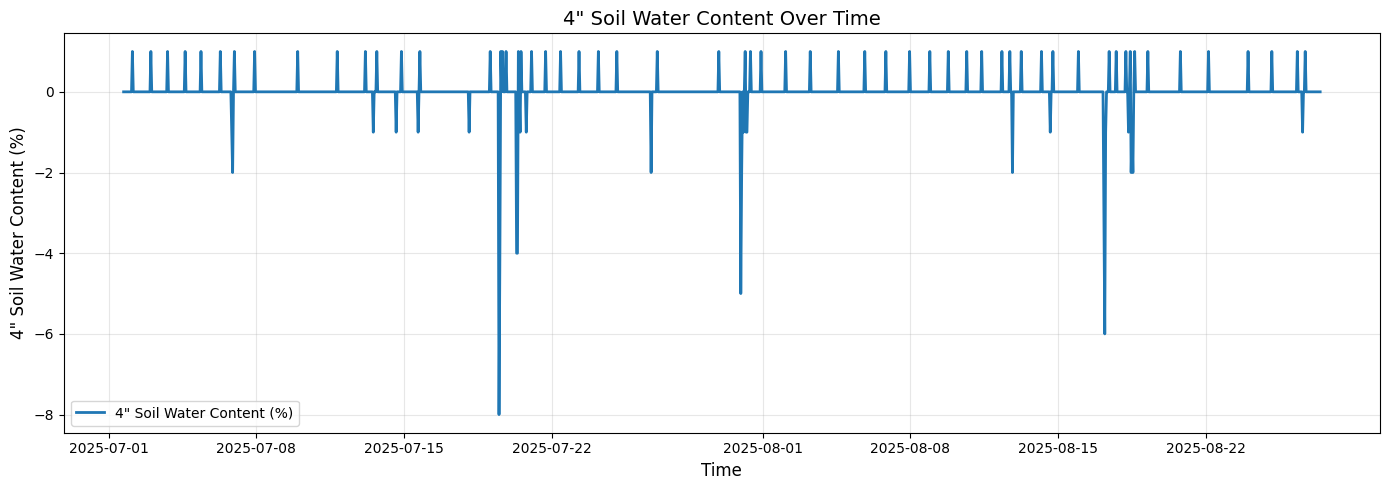

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the stationary dataset (or use df_stationary directly)
df = df_stationary.copy()

# Plot
plt.figure(figsize=(14,5))
plt.plot(df.index, df['4" Soil Water Content (%)'], label='4" Soil Water Content (%)', linewidth=2)

plt.title('4" Soil Water Content Over Time', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('4" Soil Water Content (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


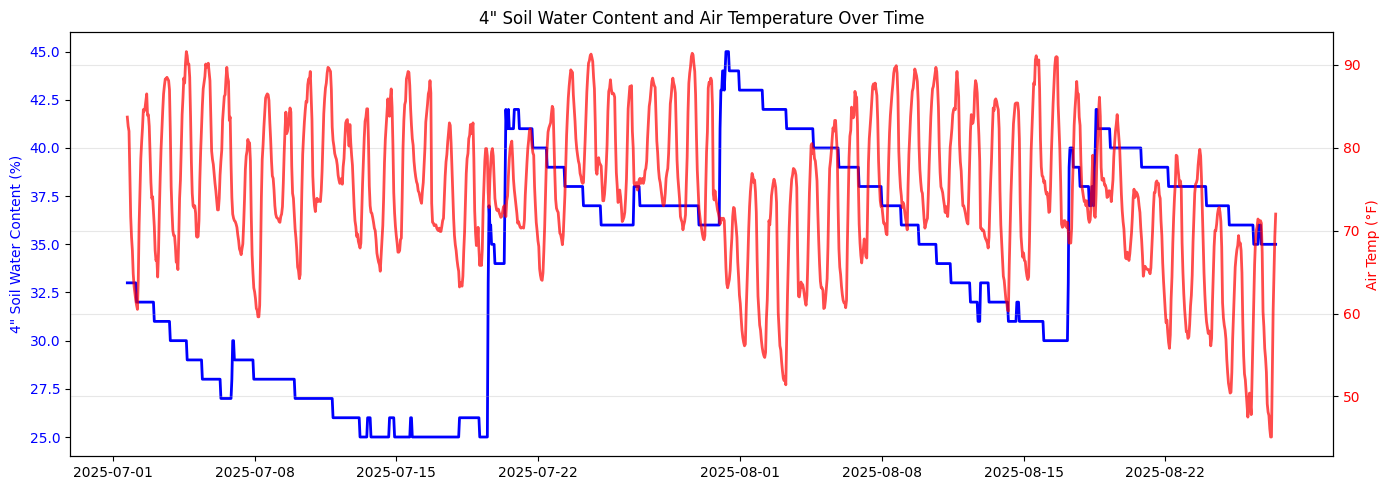

In [15]:
import matplotlib.pyplot as plt

# Use your raw cleaned dataset (not differenced)
df_raw = pd.read_csv("Table_Hrly_ACRE_clean.csv")
df_raw['Time (LST)'] = pd.to_datetime(df_raw['Time (LST)'])
df_raw = df_raw.set_index('Time (LST)')

plt.figure(figsize=(14,5))

# Left axis for soil moisture
ax1 = plt.gca()
ax1.plot(df_raw.index, df_raw['4" Soil Water Content (%)'], color='blue', label='4" Soil Water Content (%)', linewidth=2)
ax1.set_ylabel('4" Soil Water Content (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right axis for air temperature
ax2 = ax1.twinx()
ax2.plot(df_raw.index, df_raw['Air Temp (°F)'], color='red', label='Air Temp (°F)', linewidth=2, alpha=0.7)
ax2.set_ylabel('Air Temp (°F)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('4" Soil Water Content and Air Temperature Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


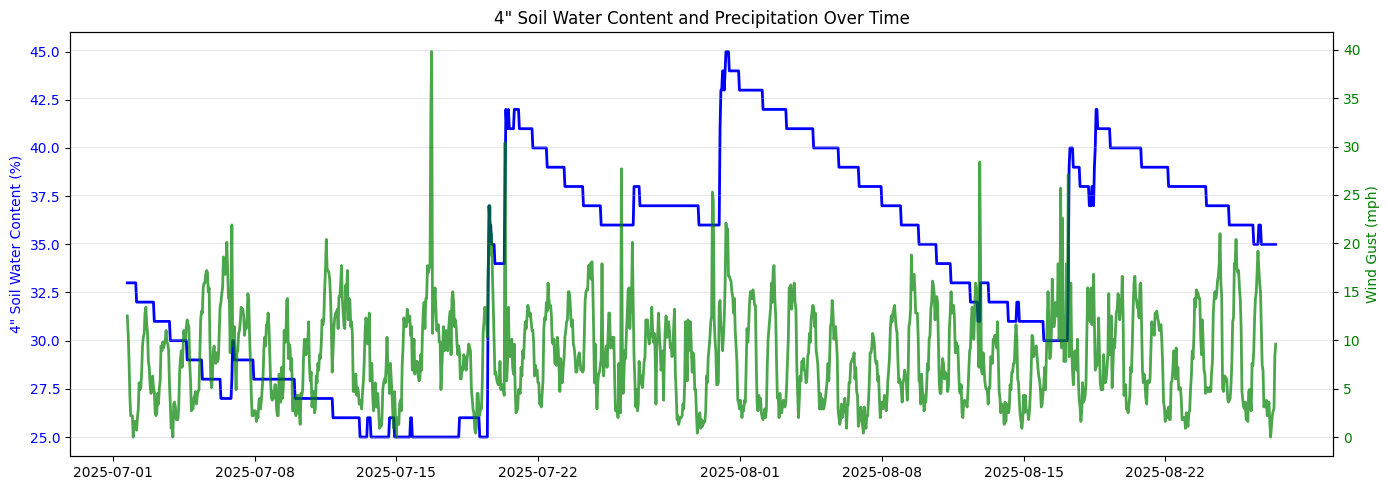

In [21]:
import matplotlib.pyplot as plt

# Load raw cleaned dataset
df_raw = pd.read_csv("Table_Hrly_ACRE_clean.csv")
df_raw['Time (LST)'] = pd.to_datetime(df_raw['Time (LST)'])
df_raw = df_raw.set_index('Time (LST)')

plt.figure(figsize=(14,5))

# Left axis: 4" soil moisture
ax1 = plt.gca()
ax1.plot(df_raw.index, df_raw['4" Soil Water Content (%)'], 
         color='blue', linewidth=2, label='4" Soil Water Content (%)')
ax1.set_ylabel('4" Soil Water Content (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right axis: precipitation
ax2 = ax1.twinx()
ax2.plot(df_raw.index, df_raw['Wind Gust (mph)'], 
         color='green', linewidth=2, alpha=0.7, label='Wind Gust (mph)')
ax2.set_ylabel('Wind Gust (mph)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('4" Soil Water Content and Precipitation Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
